Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import string


In [2]:
#Récupération des données
df=pd.read_csv("movies2023.csv")
df.head(10)

,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,848326,Rebel Moon - Part One: A Child of Fire,2136.300,When a peaceful colony on the edge of the gala...,Science Fiction,"Sofia Boutella, Michiel Huisman, Ed Skrein, Dj...",Zack Snyder,6.442,2023.0
1,572802,Aquaman and the Lost Kingdom,1605.303,"Black Manta, still driven by the need to aveng...","Action, Adventure, Fantasy","Jason Momoa, Patrick Wilson, Yahya Abdul-Matee...",James Wan,6.539,2023.0
2,695721,The Hunger Games: The Ballad of Songbirds & Sn...,1509.974,64 years before he becomes the tyrannical pres...,"Drama, Science Fiction, Action","Tom Blyth, Rachel Zegler, Peter Dinklage, Jaso...",Francis Lawrence,7.246,2023.0
3,1029575,The Family Plan,954.371,"Dan Morgan is many things: a devoted husband, ...","Action, Comedy","Mark Wahlberg, Michelle Monaghan, Maggie Q, Zo...",Simon Cellan Jones,7.366,2023.0
4,787699,Wonka,949.214,Willy Wonka – chock-full of ideas and determin...,"Comedy, Family, Fantasy","Timothée Chalamet, Calah Lane, Keegan-Michael ...",Paul King,7.159,2023.0
5,891699,Silent Night,945.220,A tormented father witnesses his young son die...,"Action, Crime","Joel Kinnaman, Kid Cudi, Harold Torres, Catali...",John Woo,5.828,2023.0
6,798141,Doors,752.379,"Without warning, millions of mysterious alien ...",Science Fiction,"Josh Peck, Wilson Bethel, Lina Esco, Kyp Malon...","Saman Kesh, Dugan O'Neal, Jeff Desom",5.012,2021.0
7,872585,Oppenheimer,746.349,The story of J. Robert Oppenheimer's role in t...,"Drama, History","Cillian Murphy, Emily Blunt, Matt Damon, Rober...",Christopher Nolan,8.119,2023.0
8,930564,Saltburn,658.860,Struggling to find his place at Oxford Univers...,"Drama, Comedy, Thriller","Barry Keoghan, Jacob Elordi, Rosamund Pike, Ri...",Emerald Fennell,7.155,2023.0
9,466420,Killers of the Flower Moon,612.671,When oil is discovered in 1920s Oklahoma under...,"Crime, Drama, History","Leonardo DiCaprio, Lily Gladstone, Robert De N...",Martin Scorsese,7.539,2023.0


Visualisation des données

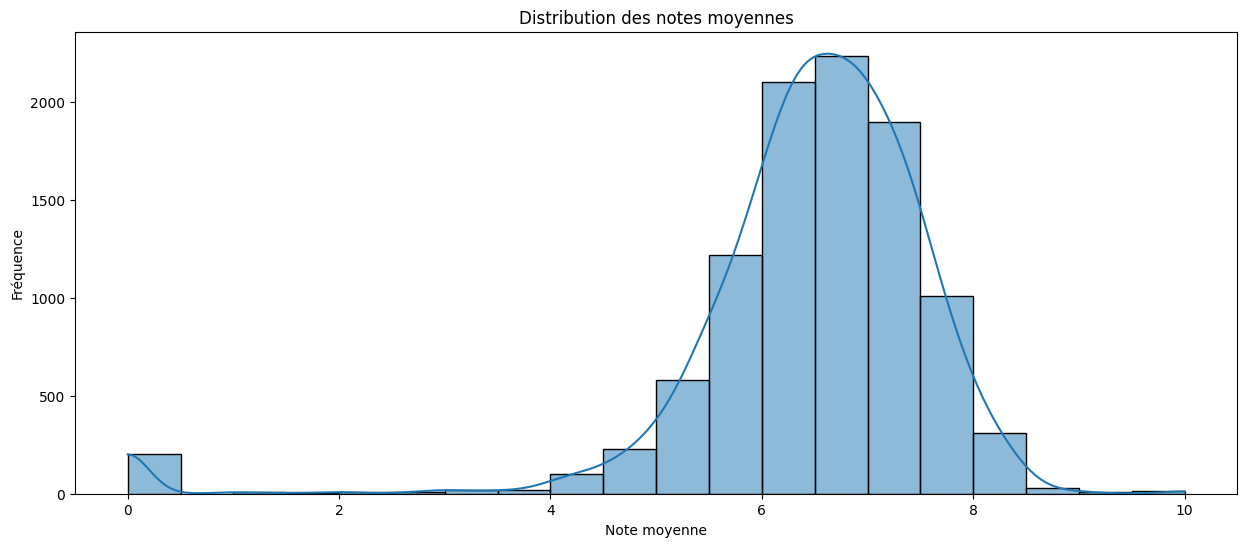

In [3]:
# Histogramme des notes moyennes
plt.figure(figsize=(15, 6))
sns.histplot(df['VoteAverage'], bins=20, kde=True)
plt.title('Distribution des notes moyennes')
plt.xlabel('Note moyenne')
plt.ylabel('Fréquence')
plt.show()

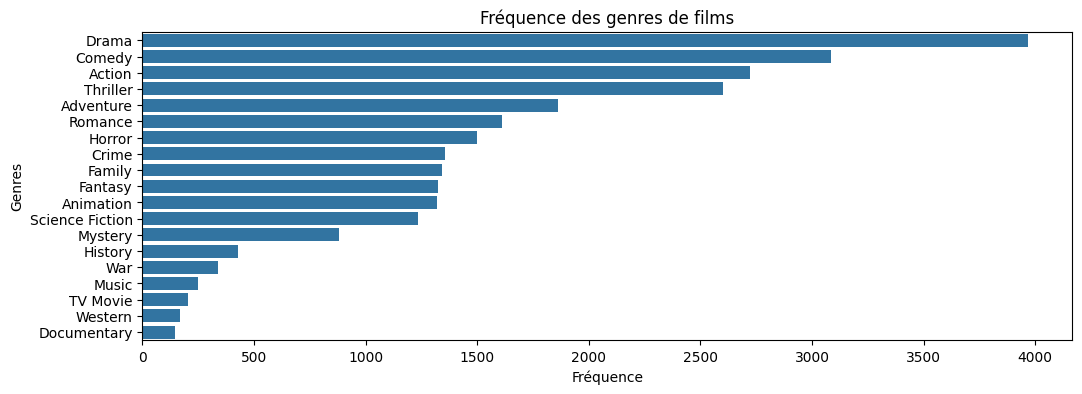

In [4]:
# Diagramme à barres pour les genres de films
plt.figure(figsize=(12, 4))
genre_counts = df['Genres'].str.strip().str.split(',').explode().str.strip().value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Fréquence des genres de films')
plt.xlabel('Fréquence')
plt.ylabel('Genres')
plt.show()

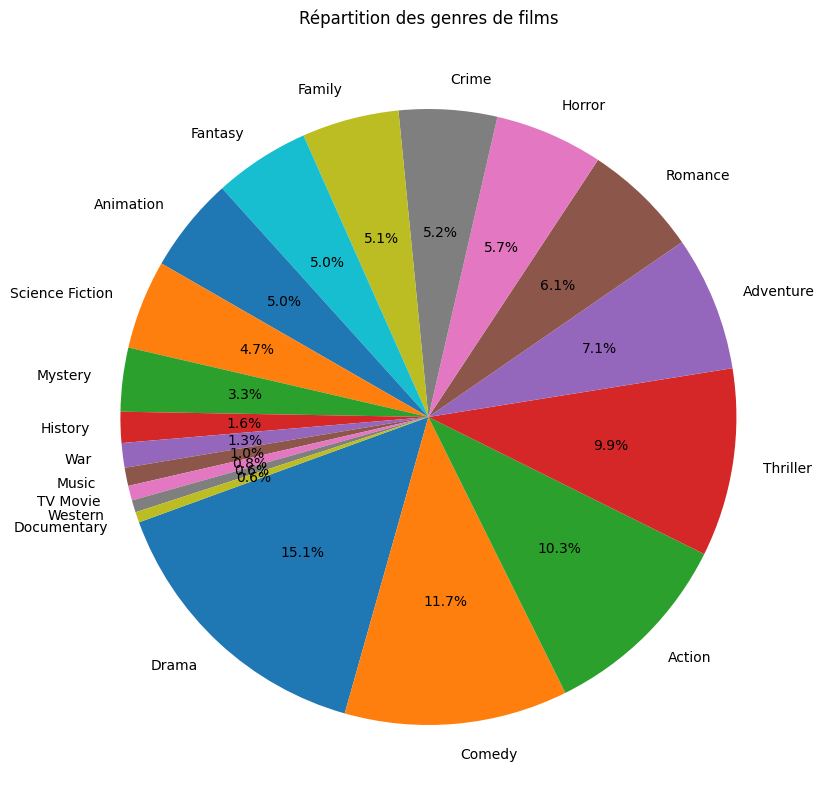

In [5]:
# Afficher le diagramme à secteurs
plt.figure(figsize=(18, 10))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=200)
plt.title('Répartition des genres de films')
plt.show()

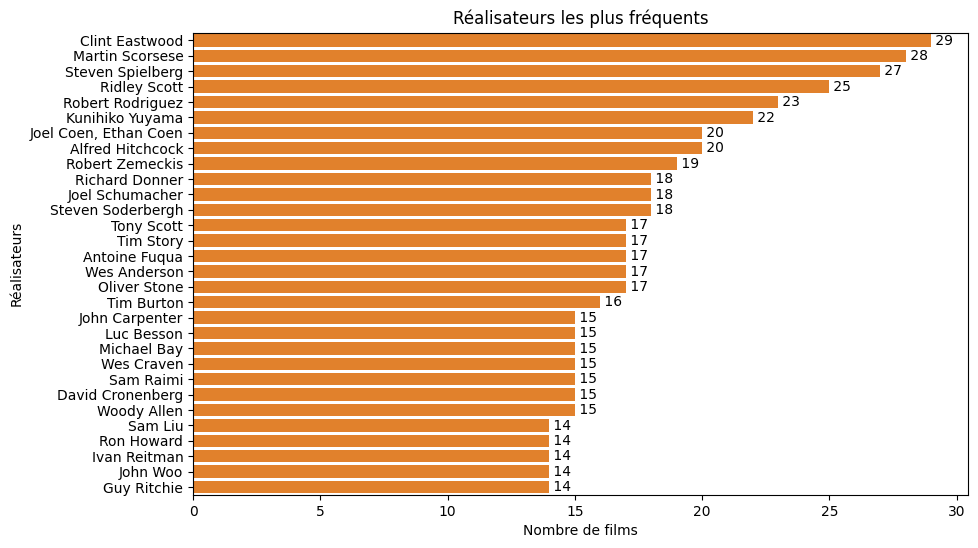

In [6]:
# Afficher le graphique à barres des réalisateurs les plus fréquents et compter leur fréquence
plt.figure(figsize=(10, 6))
director_counts = df['Directors'].str.strip().value_counts().head(30)
sns.barplot(x=director_counts.values, y=director_counts.index)
bar_plot = sns.barplot(x=director_counts.values, y=director_counts.index)
plt.title('Réalisateurs les plus fréquents')
plt.xlabel('Nombre de films')
plt.ylabel('Réalisateurs')
# Afficher les valeurs exactes à côté des barres
for index, value in enumerate(director_counts.values):
    bar_plot.text(value, index, f' {value}', ha='left', va='center')
plt.show()

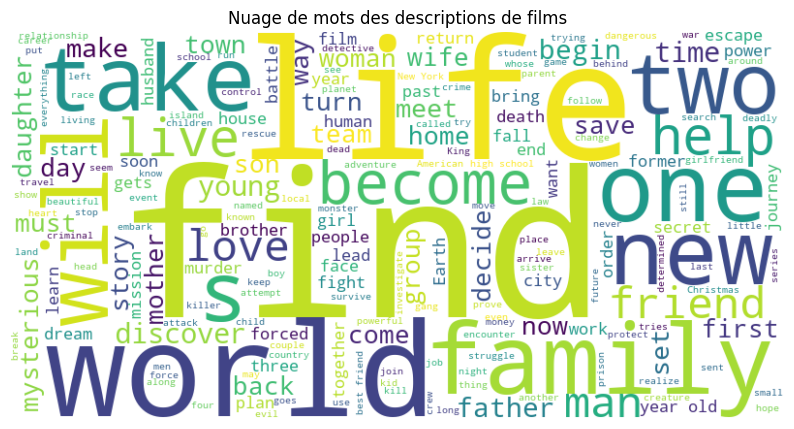

In [7]:
# Concaténer toutes les descriptions de films
text = ' '.join(df['Overview'].fillna(''))
# Créer et afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des descriptions de films')
plt.show()

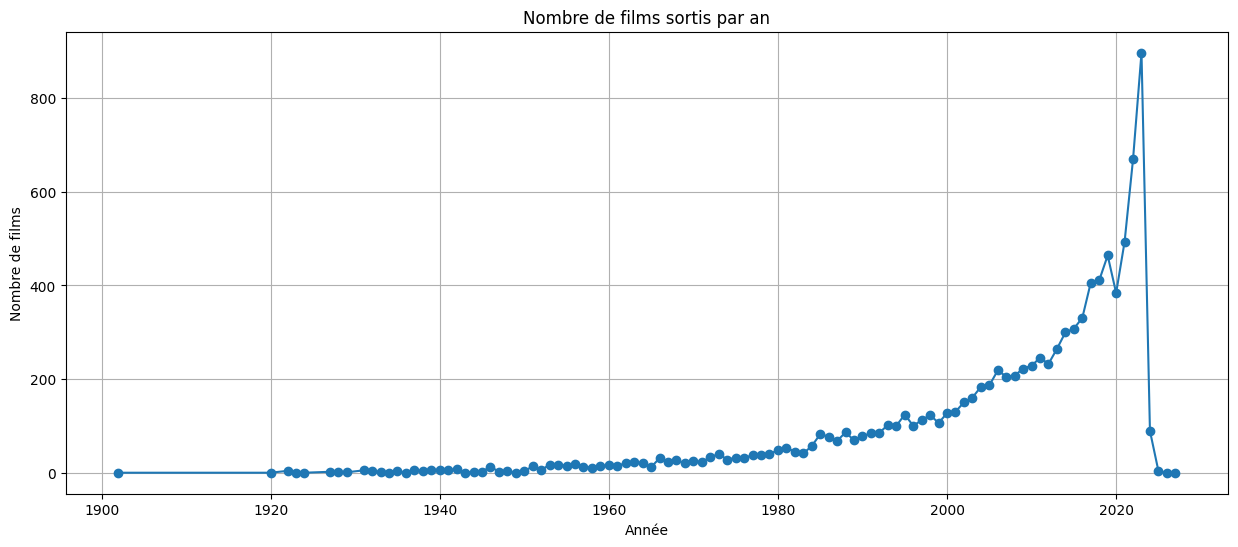

In [8]:
# Convertir la colonne ReleaseYear en datetime et compter les sorties par année
df['ReleaseYear'] = pd.to_datetime(df['ReleaseYear'], format='%Y')
yearly_counts = df['ReleaseYear'].dt.year.value_counts().sort_index()
# Afficher le graphique temporel
plt.figure(figsize=(15, 6))
yearly_counts.plot(marker='o')
plt.title('Nombre de films sortis par an')
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.grid(True)
plt.show()

Préprocessing

In [9]:
# Compter les valeurs manquantes par colonne
missing_values_count = df.isna().sum()
# Afficher les colonnes avec des valeurs manquantes et leur décompte respectif
print(missing_values_count[missing_values_count > 0])


Overview       42
Genres         37
Actors         47
Directors      46
ReleaseYear    13
dtype: int64


In [10]:
# Identifier les lignes avec des valeurs manquantes
rows_with_missing_values = df[df.isnull().any(axis=1)]
# Afficher les lignes où il y a au moins une valeur manquante
rows_with_missing_values


,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
88,846920,Street Savages,207.182,A crime boss in a dangerous neighborhood does ...,Action,NaN,Latavious Flournoy,0.0,2020-01-01
139,1070830,Una aventura gigante,155.013,NaN,Animation,"Gina Yangali, Merly Morello, Yiddá Eslava, Gus...",Eduardo Schuldt,7.2,2023-01-01
143,1070830,Una aventura gigante,155.013,NaN,Animation,"Gina Yangali, Merly Morello, Yiddá Eslava, Gus...",Eduardo Schuldt,7.2,2023-01-01
172,1217134,Sana Ol Pulubi,89.790,I WISH EVERYONE HAS THIS KINDNESS TO GIVE TO T...,NaN,NaN,NaN,0.0,2023-01-01
179,1156593,Your Fault,110.608,NaN,"Drama, Romance","Nicole Wallace, Gabriel Guevara",Domingo González,0.0,NaT
...,...,...,...,...,...,...,...,...,...
9353,1206729,Some Girls Hate Dresses,15.611,A nostalgic look into the 90s British tomboy t...,NaN,NaN,Somina Fombo,0.0,2024-01-01
9604,1209282,Your Life Without Me,15.371,Magdi and Ildikó wish to live forever to assur...,NaN,NaN,Anna Rubi,0.0,2024-01-01
9761,185698,Double Rope Torture,15.222,Two sisters are captured by a bounty hunter fo...,NaN,"Kaori Asô, Miki Takakura, Ayu Kiyokawa, Tatsuy...",Ikuo Sekimoto,2.0,1985-01-01
9883,1221210,A Portrait of Jianghu: The Legend,20.664,NaN,"Animation, Action",NaN,Zhou Fei Long,10.0,2023-01-01


In [11]:
# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)
# Réinitialiser les index
df.reset_index(drop=True, inplace=True)
# Compter les valeurs manquantes par colonne
missing_values_count = df.isna().sum()
# Afficher les colonnes avec des valeurs manquantes et leur décompte respectif
print(missing_values_count[missing_values_count > 0])
# Afficher la forme du DataFrame après la suppression et la réinitialisation des index
print(df.shape)

Series([], dtype: int64)
(9875, 9)


In [12]:
# Compter le nombre d'occurrences de chaque titre
movie_counts = df['MovieID'].value_counts()
# Filtrer les titres qui apparaissent plus d'une fois
duplicated_movies = movie_counts[movie_counts > 1]
# Afficher le nombre de titres qui apparaissent plus d'une fois
print(f"Nombre de films apparaissant plus d'une fois : {len(duplicated_movies)}")
duplicated_movies


Nombre de films apparaissant plus d'une fois : 1435


MovieID
7278      4
6466      4
9603      4
5548      3
262543    3
         ..
16538     2
460458    2
13595     2
422       2
611914    2
Name: count, Length: 1435, dtype: int64

In [13]:
# Supprimer les duplicatas dans la colonne 'MovieID'
df.drop_duplicates(subset='MovieID', keep='first', inplace=True)
# Réinitialiser les index
df.reset_index(drop=True, inplace=True)


In [14]:
# Compter le nombre d'occurrences de chaque titre
movie_counts = df['MovieID'].value_counts()
# Filtrer les titres qui apparaissent plus d'une fois
duplicated_movies = movie_counts[movie_counts > 1]
# Afficher le nombre de titres qui apparaissent plus d'une fois
print(f"Nombre de films apparaissant plus d'une fois : {len(duplicated_movies)}")
duplicated_movies

Nombre de films apparaissant plus d'une fois : 0


Series([], Name: count, dtype: int64)

In [15]:
# Afficher la forme du DataFrame après la suppression des doublons
print(df.shape)

(8367, 9)


In [16]:
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()
print("Colonnes non numériques :", non_numeric_columns)

Colonnes non numériques : ['Title', 'Overview', 'Genres', 'Actors', 'Directors', 'ReleaseYear']


In [17]:
df['ReleaseYear'] = pd.to_numeric(df['ReleaseYear'])
df.head(2)

,MovieID,Title,Popularity,Overview,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,848326,Rebel Moon - Part One: A Child of Fire,2136.300,When a peaceful colony on the edge of the gala...,Science Fiction,"Sofia Boutella, Michiel Huisman, Ed Skrein, Dj...",Zack Snyder,6.442,1672531200000000000
1,572802,Aquaman and the Lost Kingdom,1605.303,"Black Manta, still driven by the need to aveng...","Action, Adventure, Fantasy","Jason Momoa, Patrick Wilson, Yahya Abdul-Matee...",James Wan,6.539,1672531200000000000


Elaboration des matrices

In [18]:
# Sélectionner uniquement les colonnes pertinentes pour le modèle
selected_columns = ['MovieID', 'Genres', 'Actors', 'Directors', 'VoteAverage', 'ReleaseYear']  # Colonnes sélectionnées
df_selected = df[selected_columns].copy()
df_selected

,MovieID,Genres,Actors,Directors,VoteAverage,ReleaseYear
0,848326,Science Fiction,"Sofia Boutella, Michiel Huisman, Ed Skrein, Dj...",Zack Snyder,6.442,1672531200000000000
1,572802,"Action, Adventure, Fantasy","Jason Momoa, Patrick Wilson, Yahya Abdul-Matee...",James Wan,6.539,1672531200000000000
2,695721,"Drama, Science Fiction, Action","Tom Blyth, Rachel Zegler, Peter Dinklage, Jaso...",Francis Lawrence,7.246,1672531200000000000
3,1029575,"Action, Comedy","Mark Wahlberg, Michelle Monaghan, Maggie Q, Zo...",Simon Cellan Jones,7.366,1672531200000000000
4,787699,"Comedy, Family, Fantasy","Timothée Chalamet, Calah Lane, Keegan-Michael ...",Paul King,7.159,1672531200000000000
...,...,...,...,...,...,...
8362,9716,"Comedy, Romance","Drew Barrymore, Edward Norton, Alan Alda, Juli...",Woody Allen,6.500,820454400000000000
8363,229297,"Comedy, Drama, Romance","Colin Firth, Emma Stone, Hamish Linklater, Mar...",Woody Allen,6.500,1388534400000000000
8364,10103,"Comedy, Romance, Drama","Jun Ji-hyun, Jang Hyuk, Kim Jung-tae, Kim Soo-...",Kwak Jae-yong,7.244,1072915200000000000
8365,25562,Comedy,"Sally Field, Kevin Kline, Robert Downey Jr., C...",Michael Hoffman,6.200,662688000000000000


In [19]:
# Convertir les colonnes catégoriques en listes pour le One-Hot Encoding
df_selected['Genres'] = df_selected['Genres'].apply(lambda x: x.split(','))
df_selected['Actors'] = df_selected['Actors'].apply(lambda x: x.split(','))
df_selected['Directors'] = df_selected['Directors'].apply(lambda x: [x])

# Appliquer le One-Hot Encoding pour les Genres, Acteurs et Réalisateurs
mlb_genres = MultiLabelBinarizer()
mlb_actors = MultiLabelBinarizer()
mlb_directors = MultiLabelBinarizer()

encoded_genres = pd.DataFrame(mlb_genres.fit_transform(df_selected['Genres']), columns=mlb_genres.classes_, index=df_selected.index)
encoded_actors = pd.DataFrame(mlb_actors.fit_transform(df_selected['Actors']), columns=mlb_actors.classes_, index=df_selected.index)
encoded_directors = pd.DataFrame(mlb_directors.fit_transform(df_selected['Directors']), columns=mlb_directors.classes_, index=df_selected.index)

# Concaténer les DataFrames encodés avec df_selected
df_final = pd.concat([df_selected.drop(['Genres', 'Actors', 'Directors'], axis=1), encoded_genres, encoded_actors, encoded_directors], axis=1)
df_final


,MovieID,VoteAverage,ReleaseYear,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,"Àlex Pastor, David Pastor",Álex de la Iglesia,Álvaro Fernández Armero,Ángel Gómez Hernández,Ángel Manuel Soto,Árni Ólafur Ásgeirsson,Éric Falardeau,Éric Rohmer,"Éric Toledano, Olivier Nakache",Óskar Thór Axelsson
0,848326,6.442,1672531200000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,572802,6.539,1672531200000000000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,695721,7.246,1672531200000000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1029575,7.366,1672531200000000000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,787699,7.159,1672531200000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8362,9716,6.500,820454400000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8363,229297,6.500,1388534400000000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8364,10103,7.244,1072915200000000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8365,25562,6.200,662688000000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Normalisation des données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final)
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=200)  # Réduisez le nombre de composants selon vos besoins
df_reduced = pca.fit_transform(scaled_data)


In [23]:
# Calcul de la similarité cosinus entre les articles réduits
article_similarity = cosine_similarity(df_reduced, df_reduced)
# Affichage des similarités
article_similarity

array([[ 1.        ,  0.13000657,  0.10807218, ..., -0.02404351,
         0.02900687,  0.03798372],
       [ 0.13000657,  1.        ,  0.02504385, ...,  0.26746852,
         0.15939045, -0.03705144],
       [ 0.10807218,  0.02504385,  1.        , ...,  0.06026714,
        -0.01997932, -0.00114346],
       ...,
       [-0.02404351,  0.26746852,  0.06026714, ...,  1.        ,
         0.23546832, -0.17592997],
       [ 0.02900687,  0.15939045, -0.01997932, ...,  0.23546832,
         1.        ,  0.21199899],
       [ 0.03798372, -0.03705144, -0.00114346, ..., -0.17592997,
         0.21199899,  1.        ]])

In [24]:
# Supposons que nous avons une matrice de similarité entre les films
num_movies = article_similarity.shape[0]
# Générer des prédictions factices pour les scores des utilisateurs
predicted_ratings = np.random.rand(num_movies, num_movies) * 5 # Échelle de notation de 0 à 5, par exemple
# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(article_similarity, predicted_ratings, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.7497112940515764


In [26]:
def get_recommendations_based_on_genre(genre, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction du genre donné
    genre_indices = df[df['Genres'].apply(lambda x: genre in x)]
    recommendations = genre_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_recommendations_based_on_actor(actor, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction de l'acteur donné
    actor_indices = df[df['Actors'].apply(lambda x: actor in x)]
    recommendations = actor_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_recommendations_based_on_director(director, article_similarity, num_recommendations=5):
    # Trouver les films similaires en fonction du réalisateur donné
    director_indices = df[df['Directors'].apply(lambda x: director in x)]
    recommendations = director_indices.index.tolist()
    return recommendations[:num_recommendations]

def get_movie_titles(indices):
    return df.iloc[indices]['Title'].tolist()

# Récupérer des recommandations basées sur le genre
genre = 'Adventure'
recommendations_genre = get_recommendations_based_on_genre(genre, article_similarity)
#print(f"Recommandations pour le genre '{genre}': {recommendations_genre}")
titles_genre = get_movie_titles(recommendations_genre)
print(f"Titres recommandés pour le genre '{genre}': {titles_genre}")

# Récupérer des recommandations basées sur l'acteur
actor = 'Daniel Radcliffe'
recommendations_actor = get_recommendations_based_on_actor(actor, article_similarity)
#print(f"Recommandations pour l'acteur '{actor}': {recommendations_actor}")
titles_actor = get_movie_titles(recommendations_actor)
print(f"Titres recommandés pour l'acteur '{actor}': {titles_actor}")
# Récupérer des recommandations basées sur le réalisateur
director = 'Quentin Tarantino'
recommendations_director = get_recommendations_based_on_director(director, article_similarity)
#print(f"Recommandations pour le réalisateur '{director}': {recommendations_director}")
titles_director = get_movie_titles(recommendations_director)
print(f"Titres recommandés pour le réalisateur '{director}': {titles_director}")


Titres recommandés pour le genre 'Adventure': ['Aquaman and the Lost Kingdom', 'The Creator', 'Skydog', 'Chicken Run: Dawn of the Nugget', 'Barbie']
Titres recommandés pour l'acteur 'Daniel Radcliffe': ["Harry Potter and the Philosopher's Stone", 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Order of the Phoenix', 'Harry Potter and the Deathly Hallows: Part 1']
Titres recommandés pour le réalisateur 'Quentin Tarantino': ['Inglourious Basterds', 'Pulp Fiction', 'Django Unchained', 'Once Upon a Time… in Hollywood', 'Kill Bill: Vol. 1']


In [27]:
# Création d'une nouvelle colonne 'Description' avec la concaténation des colonnes pertinentes
df['Description'] = df['Overview'] + ' ' + df['Actors'] + ' ' + df['Directors'] + ' ' + df['Genres']

# Sélection des colonnes nécessaires pour le nouveau DataFrame
new_df = df[['MovieID', 'Title', 'Description']].copy()
new_df

,MovieID,Title,Description
0,848326,Rebel Moon - Part One: A Child of Fire,When a peaceful colony on the edge of the gala...
1,572802,Aquaman and the Lost Kingdom,"Black Manta, still driven by the need to aveng..."
2,695721,The Hunger Games: The Ballad of Songbirds & Sn...,64 years before he becomes the tyrannical pres...
3,1029575,The Family Plan,"Dan Morgan is many things: a devoted husband, ..."
4,787699,Wonka,Willy Wonka – chock-full of ideas and determin...
...,...,...,...
8362,9716,Everyone Says I Love You,A New York girl sets her father up with a beau...
8363,229297,Magic in the Moonlight,"Set in the 1920s French Riviera, a master magi..."
8364,10103,Windstruck,"Kyung-jin, a police officer who finds herself ..."
8365,25562,Soapdish,Celeste Talbert is the star of the long-runnin...


In [28]:
# Liste des stopwords en anglais
stop_words = set(stopwords.words('english'))
# Fonction pour prétraiter le texte
def preprocess_text(text):
    # Convertir le texte en minuscules
    text = text.lower()
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = text.split()
    # Supprimer les stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Reconstruire le texte traité
    processed_text = ' '.join(tokens)
    return processed_text
# Appliquer le prétraitement aux descriptions
new_df['Processed_Description'] = new_df['Description'].apply(preprocess_text)
# Initialisation de CountVectorizer avec le traitement des données (stopwords, etc.)
vectorizer = CountVectorizer()
# Transformer les descriptions prétraitées en une matrice de compte de mots
description_matrix = vectorizer.fit_transform(new_df['Processed_Description'])
# Calcul de la similarité cosinus entre les descriptions
description_similarity = cosine_similarity(description_matrix, description_matrix)
description_similarity


array([[1.        , 0.05546202, 0.06677299, ..., 0.00892075, 0.03832165,
        0.04073191],
       [0.05546202, 1.        , 0.02200653, ..., 0.        , 0.02736447,
        0.05817115],
       [0.06677299, 0.02200653, 1.        , ..., 0.009439  , 0.01351598,
        0.03352084],
       ...,
       [0.00892075, 0.        , 0.009439  , ..., 1.        , 0.01173712,
        0.01663378],
       [0.03832165, 0.02736447, 0.01351598, ..., 0.01173712, 1.        ,
        0.10122814],
       [0.04073191, 0.05817115, 0.03352084, ..., 0.01663378, 0.10122814,
        1.        ]])

In [29]:
# Supposons que nous avons une matrice de similarité entre les films
num_movies = description_similarity.shape[0]
# Générer des prédictions factices pour les scores des utilisateurs
predicted_ratings3 = np.random.rand(num_movies, num_movies) * 5 # Échelle de notation de 0 à 5, par exemple
# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(description_similarity, predicted_ratings3, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.858544608460844


In [30]:
def get_movie_recommendations_by_title(movie_title, df, description_similarity, num_recommendations=5):
    # Trouver l'index du film dans le DataFrame
    movie_index = df[df['Title'] == movie_title].index[0]
    
    # Obtenir les indices des films similaires pour le film donné
    similar_movies = sorted(list(enumerate(description_similarity[movie_index])), key=lambda x: x[1], reverse=True)
    
    # Récupérer les titres des films recommandés
    recommended_movie_indices = [movie[0] for movie in similar_movies[1:num_recommendations+1]]  # Exclut le film lui-même
    recommended_movies = df.iloc[recommended_movie_indices]['Title'].tolist()
    
    return recommended_movies

# Exemple : obtenir des recommandations pour un titre de film spécifique
movie_title = 'Chicken Run: Dawn of the Nugget'  # Remplacez par le titre du film pour lequel vous voulez des recommandations
num_recommendations = 10  # Nombre de recommandations à générer
recommendations = get_movie_recommendations_by_title(movie_title, new_df, description_similarity, num_recommendations)

# Afficher les recommandations
print(f"Recommandations pour le film '{movie_title}': {recommendations}")


Recommandations pour le film 'Chicken Run: Dawn of the Nugget': ['Flushed Away', 'The Tale of Despereaux', 'Migration', 'Peter Rabbit 2: The Runaway', 'Bambi', 'Harry Potter and the Order of the Phoenix', 'Maleficent: Mistress of Evil', 'Merry Madagascar', 'Rogue One: A Star Wars Story', 'Harry Potter and the Chamber of Secrets']


In [ ]:
# Enregistrement de la matrice de similarité dans un fichier
np.save('articlesimilarity.npy', article_similarity)
# Enregistrement de la matrice de similarité dans un fichier
np.save('descriptionsimilarity.npy', description_similarity)